# Assignment 2

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network.
For this assignment three methods are developed with the goal of pricing the games:
1. Building a CNN that does not take into consideration that some screenshots belong to the same game.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by using multiple screenshots of a game as input of a multi-branch CNN with a concatenated layer.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by stitching the screenshots of a game together to create one large image. This large image is then fed into the CNN.  

First, some general pre-processing is discussed. This ensures that the same splits will be used for each method. Then, for each method the pre-processing steps are discussed. Then each model with the necessary evaluation criteria is built. Then, based on the the evaluation metric, the best of the three beforementioned methods is selected. Lastly, some interpretability techniques to get insights on the model is given. 

To start, the necessary packages and data are loaded in. The data with for each game the related price and images are included. Additionally, a path is created to where the images are stored on the local device.

In [1]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn import metrics

In [ ]:
# Set the location of where the images are stored. Adjust to the correct location when running the code!

# For Methodologies 1 and 3
# image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'
# For Methodology 2
image_location = 'D:/images/stitched'

#  Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

data1 = pd.DataFrame(data) #Make sure that the data has the DataFrame format
data1.head() #print the first 5 rows with data

## Pre-processing

### Exploratory data analysis


In [ ]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(data1))
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)

In [ ]:
#Make a boxplot of the feature 'price'
feature_data = selected_games['price']

# Create a boxplot using matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(feature_data)
plt.title('Boxplot of {}'.format('feature_name'))
plt.ylabel('Values')
plt.show()

#calculate some quantiles
Q1 = feature_data.quantile(0.25)
Q2 = feature_data.quantile(0.50)
Q3 = feature_data.quantile(0.75)
Q4 = feature_data.quantile(0.99)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

print('Q1: ', Q1, 'Q2: ', Q2, 'Q3: ', Q3, 'Q4: ', Q4)
#Based on these quantiles its clear that some of these outliers can be taken out.

In [ ]:
# Remove the games that have a price larger than 100 USD from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]
# The dataset also includes 'bundle' games. these bundles contain multiple games. They have a very high price. As they are not in the scope of this model they are removed.

### Image augmentation

It is the same for the different methdologies

A key aspect of the pre-processing step is normalizing the images and performing some data augmentations (ex. rotations, flips, ...). When performing this pre-processing account must be taken of the fact that there are over 125k images available. This makes it very difficult to manually load in and augment the images. A workaround for this is by using the ImageDataGenerator function in combination with a flow_from_dataframe function (inspired by the following stackoverflow question: https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model). The ImageDataGenerator progressively loads images into the memory while training the model. 

In [ ]:
# For the training images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

# For the validation images
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

#For the test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

### Some global parameters

In [ ]:
width = 224 
height = 224 
#height width
image_size = (height, width)

#batch size
batch_size = 32

## 1. CNN that does not take into consideration that images belong to the same game

### Pre-processing

#### Train - test split

A key aspect of this assignment is accounting for the fact that a game can have multiple images. Therefore, when splitting the data into the training, validation, test split, this split should be made based on the games and not the seperate images. For this assignment the decision was made to split our data 60/20/20. 

Note that in order to also create a dataset for validation, a train-test split must be performed two times. In the first split the test set is generated. In the second split, the training set from the initial split is used to generate a training and a validation dataset.

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

#### Developing the dataframe structure

As the flow_from_dataframe function is used, first, a dataset with in first column the screenshot (the feature) and in the second column the price (the target) is created for respectively the training, validation and test set.  

In [ ]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

val_label_df = pd.DataFrame(val_data)


# Do the same for the test set
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

test_label_df = pd.DataFrame(test_data)

Next, apply the generators to the dataframes. These generators will be used as input.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size,
                                              batch_size=batch_size)

TO DO: add an illustration of how image generator adapts the images.

### Architecture of the model

Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(height, width, 3))


base_model = ResNet50(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    pooling=None
)

# Freeze the base model
base_model.trainable = False

x = base_model(inputs, training=False)

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
x = layers.BatchNormalization()(x) # inspired by https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ 
outputs = layers.Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = keras.Model(inputs, outputs)

TO DO: add a nice image with the architecture
This code is to save a nice visualisation of the model. Then this visualisation should be put in this spot.

In [ ]:
from keras.utils import plot_model
import pydot
#plot_model(model, "multi_input_and_output_model_8 _input.png", show_shapes=True)
model.summary()

### Prevention of overfitting

Cannot use MAPE because there are prices equal to zero => will not work
How we are preventing overfitting:
- keeping track of a validation set and early stopping if the validation set has reached its minimum level (so the delta does not increase anymore)
- Dropout
- Batch normalization

Loss function: using rmse 
This depends on your loss function. In many circumstances it makes sense to give more weight to points further away from the mean--that is, being off by 10 is more than twice as bad as being off by 5. In such cases RMSE is a more appropriate measure of error. https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error 



As mentioned above, Cyclical Learning Rates enables our learning rate to oscillate back and forth between a lower and upper bound.

So, why bother going through all the trouble?

Why not just monotonically decrease our learning rate, just as we’ve always done?

The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.

Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.

Instead, we can use Cyclical Learning Rates to oscillate our learning rate between upper and lower bounds, enabling us to:

Have more freedom in our initial learning rate choices.
Break out of saddle points and local minima.
In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

 Loss function: the parameter that is used to optimize the model, i.e. the loss function is minimized by the model
 Metric: what is used to evaluate the model performance (this can be used to compare different models)

In [ ]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam, SGD
from keras.losses import Huber

#set the CLR options
clr_step_size = int(4 * (len(train_generator)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 1e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0005)

# Adding an early stopping mechanism
EarlyStoppinng = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=1,
    start_from_epoch=1,
)

model.compile(optimizer=opt, loss=Huber(delta=1.0), metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")


### Fitting the model

In [ ]:
history = model.fit(
    train_generator,
    callbacks=[ EarlyStoppinng, clr_triangular],
    steps_per_epoch=train_generator.n//batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps = val_generator.n//batch_size
)

Plot a curve to analyse the learning rate

In [ ]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot how the cyclical learning rate moves
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

### Model evaluation


In [ ]:
loss, mean_absolute_error = model.evaluate(test_generator, steps = test_generator.n//batch_size)
print("Test MAE:", mean_absolute_error)

Adding the figure fitted vs actual

In [ ]:
pred = []

for i in range(len(test_label_df)):
    filename = test_label_df.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    price_difference = predictions[0][0] - test_label_df.iloc[i]["price"]
    pred.append({'price': predictions[0][0], 'difference': price_difference})

    print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

In [ ]:
plt.figure(figsize = (7,7))
plt.axis([-500, 10000, -500, 10000])
plt.scatter(test_label_df['price'], predictions_test['price'])
plt.title("Test Set: Actual vs predicted price of the video game")
plt.ylabel("Predicted price", size=20)
plt.xlabel("Actual price", size=20)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_label_df['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_label_df['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_label_df['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_label_df['price'], predictions_test['price']))

### Examples of predictions for images

In [ ]:
# Define the image location
number = 450
print(test_label_df.loc[number, "screenshot"])
filename = test_label_df.loc[number, "screenshot"]

# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(height, width))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = img_array/255.0
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])

### Interpretability using saliency plots

In [ ]:
from matplotlib import pyplot as plt

#matplotlib inline
# Define the image location
number1 = 500 #780 is the tanks
number2 = 507
#print(test_label_df.loc[number, "screenshot"])
filename1 = test_label_df.loc[number1, "screenshot"]
price1 = test_label_df.loc[number1, "price"]
filename2 = test_label_df.loc[number2, "screenshot"]
price2 = test_label_df.loc[number2, "price"]

# Construct the full path to the image
image_path1 = os.path.join(image_location, filename1)
image_path2 = os.path.join(image_location, filename2)

# Load and display the image
plt.rcParams['figure.figsize'] = (18, 6)

img1 = keras.utils.load_img(image_path1, target_size=(height, width))
img2 = keras.utils.load_img(image_path2, target_size=(height, width))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [ ]:
# Github
# https://github.com/keisen/tf-keras-vis/tree/master


# Preprocess images, so that they are normalized
img_array = keras.utils.img_to_array(img1)
img_array = img_array / 255.0  # Normalize the image data
#print(img_array.shape)
#img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis
#print(img_array.shape)

# Model modifier: Such that the last layer has a linear activation function.
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()

#Score function: should return the target score
def score(output):
    return output[0][0]

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import num_of_gpus

# Create Gradcam object
saliency = Saliency(loaded_model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
saliency_map = saliency(score, img_array)

In [ ]:
image_title = [price1]
# Plot
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

ax.set_title(image_title, fontsize=16)
ax.imshow(saliency_map[0], cmap='jet')
ax.axis('off')

plt.tight_layout()
plt.show()

## 2. Multi-input CNN

### Pre-processing

#### Developing the dataframe

In [ ]:
screenshots_new = selected_games_no_outliers['screenshots'].apply(pd.Series)
screenshots_new.head()

Fill in the NaNs with other screenshots. So that in the end have inputs of normal size. The images in the other columns are selected at random from the previous columns. 

In [ ]:
# Function to replace NaN values with a random non-NaN value from previous columns
def replace_nan_with_random(df):
    for index, row in df.iterrows():
        for col_index, value in row.items():
            if pd.isnull(value):
                # Get previous non-NaN values in the row
                previous_values = row[:col_index][::-1]
                previous_values = previous_values.dropna()
                
                if not previous_values.empty:
                    # Select a random non-NaN value from previous columns
                    random_value = previous_values.sample().iloc[0]
                    # Replace NaN with the randomly selected value
                    df.at[index, col_index] = random_value

# Call the function to replace NaN values with random non-NaN values
replace_nan_with_random(screenshots_new)

# Add the price
result_df = pd.concat([selected_games_no_outliers['price'], screenshots_new], axis=1)
result_df.head()

#### Train - test split

In [ ]:
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(result_df, test_size=0.2, random_state=42)
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2
#train_games.head()

In [ ]:
def generate_generator_multiple(generator, dataframe, batch_size, img_height, img_width, num_columns=10):
    generators = []
    
    for i in range(num_columns):
        genX = generator.flow_from_dataframe(dataframe=dataframe, directory=image_location, color_mode="rgb",
                                             target_size=(img_height, img_width),
                                             x_col=i, y_col="price", has_ext=True,
                                             class_mode="other",
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=7)
        generators.append(genX)
       

    while True:
        batch_X = []
        batch_Y = None
        
        for genX in generators:
            X, Y = genX.next()
            batch_X.append(X)
            if batch_Y is None:
                batch_Y = Y
        
        yield batch_X, batch_Y

In [ ]:
inputgenerator=generate_generator_multiple(generator=train_datagen, dataframe=train_games,
                                           batch_size=batch_size,
                                           img_height=height,
                                           img_width=width)       

valgenerator=generate_generator_multiple(val_datagen, dataframe=val_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)   
     
testgenerator=generate_generator_multiple(test_datagen, dataframe=test_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)

### Architecture

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import activations


input_x_1 = Input(shape=(224, 224, 3), name='input_1')
input_x_2 = Input(shape=(224, 224, 3), name='input_2')
input_x_3 = Input(shape=(224, 224, 3), name='input_3')
input_x_4 = Input(shape=(224, 224, 3), name='input_4')
input_x_5 = Input(shape=(224, 224, 3), name='input_5')
input_x_6 = Input(shape=(224, 224, 3), name='input_6')
input_x_7 = Input(shape=(224, 224, 3), name='input_7')
input_x_8 = Input(shape=(224, 224, 3), name='input_8')
input_x_9 = Input(shape=(224, 224, 3), name='input_9')
input_x_10 = Input(shape=(224, 224, 3), name='input_10')

#Shared layer
base_model = ResNet50(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    input_shape= (224, 224, 3),
    pooling=None
)
base_model.trainable = False


x1 = base_model(input_x_1, training=False)
x2 = base_model(input_x_2, training=False)
x3 = base_model(input_x_3, training=False)
x4 = base_model(input_x_4, training=False)
x5 = base_model(input_x_5, training=False)
x6 = base_model(input_x_6, training=False)
x7 = base_model(input_x_7, training=False)
x8 = base_model(input_x_8, training=False)
x9 = base_model(input_x_9, training=False)
x10 = base_model(input_x_10, training=False)

x = Concatenate()([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10])

# Add a layer on top
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3, name="top_dropout")(x)
x = BatchNormalization()(x)
# inspired by https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ 
outputs = Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = Model(inputs= [input_x_1, input_x_2, input_x_3, input_x_4, input_x_5, input_x_6, input_x_7, input_x_8, input_x_9, input_x_10], outputs= outputs)


To do: add nice image with the architecture 

In [ ]:
from keras.utils import plot_model
import pydot
#plot_model(model, "multi_input_and_output_model_8 _input.png", show_shapes=True)
model.summary()

In [ ]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam, SGD

#set the CLR options
clr_step_size = int(4 * (len(train_games)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 5e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0007)

# Adding an early stopping mechanism
EarlyStopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    start_from_epoch=0)

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")

### Fitting the model

In [ ]:
# Fitting the model

history = model.fit(
    inputgenerator,
    steps_per_epoch=len(train_games)//batch_size,
    epochs=5,
    validation_data=testgenerator,
    validation_steps = len(test_games)//batch_size, 
    callbacks = [EarlyStopping_cb , clr_triangular]
)

In [ ]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model evaluation

In [ ]:
# Evaluate model
loss, mean_absolute_error = model.evaluate(valgenerator, steps=len(val_games)//batch_size)

In [ ]:
pred = []

for i in range(len(test_games)):

    image_paths = [os.path.join(image_location, filename) for filename in test_games.iloc[i, 1:11]]  # Assuming columns "0" to "8" contain the image filenames
    images = [keras.utils.load_img(image_path, target_size=(224, 224)) for image_path in image_paths]

    img_arrays = [keras.utils.img_to_array(img) for img in images]
    img_arrays = [img_array / 255.0 for img_array in img_arrays]
    img_arrays = [tensorflow.expand_dims(img_array, 0) for img_array in img_arrays]  # Create batch axis for each image


    predictions = model.predict(img_arrays)
    price_difference = predictions[0][0] - test_games.iloc[i]['price']
    pred.append({'price': predictions[0][0], 'difference': price_difference})
    print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

In [ ]:
plt.figure(figsize = (7,7))
plt.axis([-100, 1000, -100, 1000])
plt.scatter(test_games['price'], predictions_test['price'])
#plt.plot([min(test_games['price']), max(test_games['price'])], [min(test_games['price']), max(test_games['price'])], color="r", linestyle="-", linewidth=2)
#plt.plot([min(test_games['price']), max(test_games['price'])], [min(test_games['price']), max(test_games['price'])], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))

## 3. Stitched images

The following part attempts to predict the price of a game based on one input of multiple screenshots. The screenshots will be stitched together per game. As in the part before a prediction was made for every screenshot without a link to the other screenshots of the game. This part tries to improve the model by linking all screenshots together and giving one input per game. 

In [67]:
#read in dataframe that contains the name of the first screenshot used in the stitching of the images and the price of the game. 
df = pd.read_csv('stitched_price.csv')

image_location = 'D:/images/stitched'


### preprocessing

#### Removing outliers

Because of the new dataframe the preprocessing has to be repeated. 

In [68]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(df)*0.1)
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = df.sample(n=num_selected_games)

In [70]:
# Remove the games that have a price larger than 100 USD from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]
# The dataset also includes 'bundle' games. these bundles contain multiple games. They have a very high price. As they are not in the scope of this model they are removed.

#### Train-test split

Re-do train test split because are working with a different dataframe than the origianl json file

In [71]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.2, random_state=42) # 0.25 * 0.8 = 0.2

In [72]:
val_games['price'] = val_games['price'].astype('float32')
test_games['price'] = test_games['price'].astype('float32')
train_games['price'] =train_games['price'].astype('float32')

In [73]:
train_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937 entries, 13676 to 9473
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   screenshot  937 non-null    object 
 1   price       937 non-null    float32
dtypes: float32(1), object(1)
memory usage: 18.3+ KB


In [74]:
# Reshape price
from sklearn.preprocessing import MinMaxScaler
target_scaler = MinMaxScaler()

test_games['price'] = target_scaler.fit_transform(test_games[['price']].values)
train_games['price'] = target_scaler.fit_transform(train_games[['price']].values)
val_games['price'] = target_scaler.fit_transform(val_games[['price']].values)

### Model setup

In [76]:
#create a training datagenerator, including data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)



# same for the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

val_generator = test_datagen.flow_from_dataframe(dataframe=val_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)


Found 750 validated image filenames.
Found 47 validated image filenames.
Found 293 validated image filenames.


In [77]:
from tensorflow.keras.applications import VGG16, ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(None,None, 3))

In [78]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

# Freeze the base model
base_model.trainable = False
model = Sequential([base_model])
# Add layers to the base model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(224,224, 3)), #add multiple convolution layers
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding = "same"),
    MaxPooling2D((2, 2)),
    # Dropout(0.20),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])


# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1, 
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Evaluate model
loss, mae = model.evaluate(val_generator)
print("Validation Mean Absolute Error:", mae)

# Save the model
model.save("fullModel_3epochs.keras")


c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - loss: 7.8598 - mae: 1.0659 - val_loss: 0.0188 - val_mae: 0.0834
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0199 - mae: 0.0763
Validation Mean Absolute Error: 0.08381935209035873


### Testing

In [79]:
# model = keras.models.load_model("my_model.keras")

pred = []

for i in range(len(test_games)):
    filename = test_games.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    pred.append({'price': predictions[0][0]})

    print('difference ', i , predictions[0][0] - test_games.iloc[i]["price"])

predictions_test = pd.DataFrame(pred)
predictions_test.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
difference  0 -0.0055518784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
difference  1 0.04372716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
difference  2 -0.14221658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
difference  3 -0.06623841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
difference  4 -0.4939907
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
difference  5 -0.2367157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
difference  6 0.00886308
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
difference  7 0.027286615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
difference  8 -0.35285985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
difference  9 0.06661465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
difference  10 0.05751232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
difference  11 -0.07777598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
difference  12 -0.24706274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
difference  13 -0.31452265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
difference  14 -0.016141348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,price
0,0.039686
1,0.066232
2,0.034642
3,0.047196
4,0.062954


In [80]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))
print('Mean absolute percentage error:', metrics.mean_absolute_percentage_error(test_games['price'], predictions_test['price']))

Mean Absolute Error: 0.14446115
Mean Squared Error: 0.050466783
Root Mean Squared Error: 0.22464813
R2 score: -0.43554704962810864
Mean absolute percentage error: 29122443000000.0


Text(0.5, 0, 'Actual')

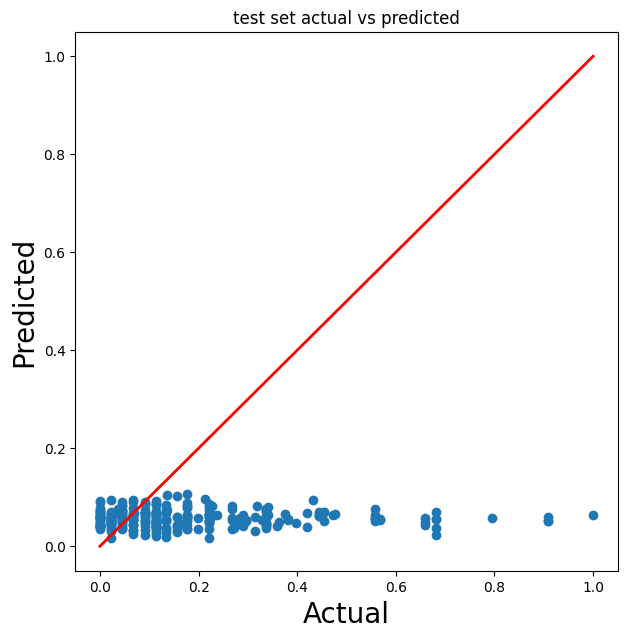

In [81]:
# plot the predicted vs actual values
plt.figure(figsize = (7,7))
plt.scatter(test_games['price'], predictions_test['price'])
plt.plot([min(test_games['price']), max(test_games['price'])], [min(test_games['price']), max(test_games['price'])], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)